In [ ]:
######## Jupyter and Ipython config and tweaks
# import ipy_autoreload
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
###### fix notebook theme: make cells wide and add a margin to output cells
from IPython.core.display import display, HTML
display(HTML("""
<style>
  .container { width:99% !important; } 
  div.cell{
    width:100%;
    margin-left:1%;
    margin-right:auto;
  }
  div.output_area {
   display: -webkit-box;
   padding: 13px;
  }
</style>"""))

In [10]:
import matplotlib
#matplotlib.use('PDF')
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib as mpl
fm = mpl.font_manager
fm.get_cachedir()

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
X_SMALL_SIZE = 8*2
SMALL_SIZE = 10*2
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

rc('font', size=SMALL_SIZE)          # controls default text sizes
rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=X_SMALL_SIZE)    # legend fontsize

In [5]:

import re
import time
import os
import sys
import gc
import numpy as np
#to dump objects
import cPickle as pickle
import operator

import pylab
from numpy.core.function_base import linspace
from numpy.lib.function_base import meshgrid
from numpy.core.numeric import array
from matplotlib import colors
from mpl_toolkits.mplot3d.axes3d import Axes3D
#from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import colorConverter

from matplotlib import cm
from collections import OrderedDict, Set

######################################################
#constants
experiment_time_stamp_idx=0
ble_mode_idx=1
tx_power_idx=2
tx_offset_idx=3
capture_idx=4
prr_1_idx=5
prr_2_idx=6
prr_ct_idx=7
rssi_avg_idx=8
rssi_stddev_idx=9
ts_delta_avg_idx=10
ts_delta_stddev_idx=11

#constatnts
Ble_1Mbit=3 #/*!< 1 Mbit/s Bluetooth Low Energy */
Ble_2Mbit=4 #/*!< 2 Mbit/s Bluetooth Low Energy */
Ble_LR125Kbit=5 #/*!< Long range 125 kbit/s (TX Only - RX supports both) */
Ble_LR500Kbit=6 #/*!< Long range 500 kbit/s (TX Only - RX supports both) */
ble_mode_str_list = ["1Mbps", "2Mbps", "LR-125Kbps", "LR-500Kbps"]
ble_mode_str_list_compact = ["1 M", "2 M", "125 K", "500 K"]

#ble_mode_str_dict = {Ble_1Mbit: "1Mbps", Ble_2Mbit:"2Mbps", Ble_LR125Kbit:"LR-125Kbps", Ble_LR500Kbit:"LR-500Kbps"}
ble_mode_str_dict = {Ble_1Mbit: "1 M", Ble_2Mbit:"2 M", Ble_LR125Kbit:"125 K", Ble_LR500Kbit:"500 K"}

def ble_mode_str(m):
  return ble_mode_str_list[m-3] if (m>=3 or m<=6) else ("RF Mode Unknown %d" %(m))

def ble_mode_str_compact(m):
  return ble_mode_str_list_compact[m-3] if (m>=3 or m<=6) else ("RF Mode Unknown %d" %(m))

plot_ts_delta_over = False
plot_rssi_diff_over = False

linestylesDict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
linestyles = linestylesDict.items()
linestyles = ['-', '--', '-.', ':']
markers = ['o', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'v', '^', '<', '>',]

def timing(f):
  def wrap(*args, **kwargs):
    time1 = time.time()
    ret = f(*args, **kwargs)
    time2 = time.time()
    print '%s function took %f ms' % (f.func_name, (time2-time1)*1000.0)
    return ret
  return wrap

def saveObject(userobj, filename):
    with open(filename, 'wb') as outputFile:
        pickle.dump(userobj, outputFile, pickle.HIGHEST_PROTOCOL)

def loadObject(filename):
    userobj = None
    with open(filename, 'rb') as inputFile:
        userobj = pickle.load(inputFile)
    return userobj

#1534763630098560        ID:10   {tx-3} :8-----------------------
line_regex = re.compile("(\d+)\s+ID\:(\d+)\s+\{(\w+)-(\d+)\}\s(.*)")
def parse_experiment_line(line):
  #93_2018_08_20_13_12_56_ble_mode_3_txpower_-20_txoffset_0_capture_0
  res = line_regex.match(line)
  parsed = None
  if res:
    ts = int(res.group(1))
    nid = int(res.group(2))
    subject = str(res.group(3))
    rd = int(res.group(4))
    lline = str(res.group(5))
    parsed = ts, nid, subject, rd, lline
  return parsed

#dirname_regex = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_ble_mode_(\d)_txpower_(-?\d+)_txoffset_(-?\d+)_capture_(\d)")
dirname_regex = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_ble_mode_(\d)_txpower_(-?\d+)_txoffset_(-?\d+)_capture_(\d)(_packet_size_(\d+))?(_nch_(\d+))?(_och_(\d+))?(_ntx_(\d+))?")
def parse_experiment_dirname(dirname):
  #93_2018_08_20_13_12_56_ble_mode_3_txpower_-20_txoffset_0_capture_0
#439_2018_09_12_14_30_34_ble_mode_6_txpower_-12_txoffset_0_capture_0_packet_size_38_nch_40_och_0
  res = dirname_regex.match(dirname)
  #print dirname
  parsed = None
  if res:
    exp_number = int(res.group(1))
    ts = [int(res.group(2)), int(res.group(3)), int(res.group(4)), int(res.group(5)), int(res.group(6)),int(res.group(7))]
    ble_mode = int(res.group(8))
    txpower = int(res.group(9))
    txoffset = int(res.group(10))
    capture = int(res.group(11))
    packet_size = 38 #PDU size
    nch = 1 #number of channels
    och = 1 #override channel 37 to non-standard 2498MHz e.g., WiFi and Bluetooth clean.
    ntx = 0
    if res.group(12):
        if str(res.group(12)).startswith("_packet_size_"):
            packet_size = int(res.group(13))
    if res.group(14):
        if str(res.group(14)).startswith("_nch_"):
            nch = int(res.group(15))
    if res.group(16):
        if str(res.group(16)).startswith("_och_"):
            och = int(res.group(17))
    if res.group(18):
        if str(res.group(18)).startswith("_ntx_"):
            ntx = int(res.group(19))
            
    parsed = [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx]
  return parsed

filename_regex = re.compile("exp(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_ble_mode_(\d)_txpower_(-?\d+)_(-?\d+)_txoffset_(-?\d+)_capture_(\d).log")
def parse_experiment_filename(log):
  res = filename_regex.match(log)
  parsed = None
  if res:
    #timestamp = float(res.group(1))
    ts = [int(res.group(1)), int(res.group(2)), int(res.group(3)), int(res.group(4)), int(res.group(5)), int(res.group(6))]
    ble_mode = int(res.group(7))
    txpower = [int(res.group(8)), int(res.group(9))]
    txoffset = int(res.group(10))
    capture = int(res.group(11))
    parsed = [ts, ble_mode, txpower, txoffset, capture]
  return parsed

def tx_status_map_bad_rx(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['-', '1', '2', 'B', ':', 'X', '\0']):
    return 0
  else:
    return 1

def tx_status_map_tx(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['1', '2', 'B', 'X']):
    return 1
  else:
    return 0

def tx_status_map_tx2(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['-', ':']):
    return 0
  elif(t in ['1', '2', 'B', 'X']):  
    return 1
  else:
    return 2
  
################################################################
##Load the Logs of the Wired Experiments
################################################################
def load_log_file(in_filename, dirname):
# rx_ok 23, crc 0, none 0, tx 1: OK 5244 of 5244, berr b0 p0 r0 0
# Rssi: -111, -127, -22, -23, -27, -22, -27, -28, -30, -23, -25, -22, -28, -25, -29, -23, -25, -28, -22, -25, -22, -22, -24, -23, -22, dB
# Ts delta: 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, ticks
# Tx status: :B-----------------------
# R 226, ID: 0x724d2a67, master: 0x724d2a67, tx power: 0 dBm, channel 37 = 2498 MHz (not std), msg: 38 bytes, mode: Ble_2Mbit, CE: 0, @ Jun 13 2018 13:01:06
#exp2018_06_14_15_06_58_ble_mode_4_txpower_0_3_txoffset_20_capture_0
  
  #experiment_parameters
  [ts, ble_mode, txpower, txoffset, capture] = parse_experiment_filename(in_filename)
  #print in_filename, [ts, ble_mode, txpower, txoffset, capture]
  ts_delta = []
  tx_status = []
  rounds = []
  tx_status_translated_acc = [0]*24
  total_1_rx = 0
  total_2_rx = 0
  total_b_rx = 0
  total_b_ok = 0
  total_1_ok = 0
  total_2_ok = 0
  rssi=[[],[],[]]
  ts_delta=[[],[],[]]
  ts_delta_crc=[[],[],[]]
  rssi_tmp = []
  rssi_tot = [0]*3
  ts_delta_tot = [0]*3
  start_processing = False

  for lline in open(os.path.join(dirname, in_filename), 'r').readlines():
    if lline:
      line=lline.strip()
      if line.startswith("Testing"):
        start_processing = True
        #print line
        continue

      if not start_processing:
        continue
      
      if line.startswith("Rssi: "):
        sstr = line.split("Rssi: ")[1].split(',')
        rssi_tmp = [int(r) for r in sstr[2:len(sstr)-1]]
        #print rssi
      elif line.startswith("Ts delta: "):
        sstr = line.split("Ts delta: ")[1].split(',')
        ts_delta_tmp = [int(r) for r in sstr[2:len(sstr)-1]]
        #print ts_delta
      elif line.startswith("Tx status: "):
        tx_status = line.split("Tx status: ")[1][1:]
        tx_status_bad_rx = [tx_status_map_bad_rx(t) for t in tx_status[1:]]
        tx_status_tx = [tx_status_map_tx(t) for t in tx_status[1:]]
        tot=len(tx_status[1:])
        tot_tx = sum(tx_status_tx)
        tot_not_ok = sum(tx_status_bad_rx)
        tot_ok = tot - tot_not_ok - tot_tx
        tot_rx = tot - tot_tx
        #print tx_status[1:], tx_status_tx, tot, tot_tx, tot_rx, tot_ok, tot_not_ok
        
        rssi_ok = []
        ts_ok = []
        ts_crc = []
        if len(tx_status) > 1:
          for i in range(1,len(tx_status)-1):
            if tx_status[i] == '-':
              rssi_ok.append(rssi_tmp[i])
              ts_ok.append(ts_delta_tmp[i])
            elif tx_status[i] == 'C':
              ts_crc.append(ts_delta_tmp[i])
              
        #rssi_ok = [rssi_tmp[i] for i in range(1,len(tx_status)-1) if tx_status[i] == '-'] if len(tx_status) > 1 and len(rssi_tmp) > 1 else []
        #ts_ok = [ts_delta_tmp[i] for i in range(1,len(tx_status)-1) if tx_status[i] == '-'] if len(tx_status) > 1 and len(ts_delta_tmp) > 1 else []

        if(tx_status[0] == '1' or tx_status[0] == '3'):
          i=0
          total_1_rx += tot_rx
          total_1_ok += tot_ok
        elif(tx_status[0] == '2'):
          i=1
          total_2_rx += tot_rx
          total_2_ok += tot_ok
        elif(tx_status[0] == 'B'):
          i=2
          total_b_rx += tot_rx
          total_b_ok += tot_ok
        else:
          i=3
          print line
        
        if i < 3 and len(rssi_ok) > 0:
          rssi[i].extend(rssi_ok)
        if i < 3 and len(ts_ok) > 0:
          ts_delta[i].extend(ts_ok)
        if i < 3 and len(ts_crc) > 0:
          ts_delta_crc[i].extend(ts_crc)
  #result = [ts, ble_mode, txpower, txoffset, capture, 1.0*total_1_ok/total_1_rx, 1.0*total_2_ok/total_2_rx,1.0*total_b_ok/total_b_rx] if start_processing else [ts, ble_mode, txpower, txoffset, capture, 0,0,0]
  prr1=1.0*total_1_ok/total_1_rx if total_1_rx != 0 else 0
  prr2=1.0*total_2_ok/total_2_rx if total_2_rx != 0 else 0
  prr3=1.0*total_b_ok/total_b_rx if total_b_rx != 0 else 0
  if(prr1 == 0 or prr2 == 0): #extend with rssi_failed and ts_failed
    result = [ts, ble_mode, txpower, txoffset, capture, -1, -1, prr3,[-127]*3,[0]*3,[0]*3,[0]*3]
    print "!Error: repeat experiment in_filename" 
  else:
    for i in range(0,3):
      if len(rssi[i]) == 0:
        rssi[i].extend([0])      
      if len(ts_delta[i]) == 0:
        ts_delta[i].extend([0])
    rssi_arr = np.array(rssi)
    #print rssi_arr
    rssi_tot = [np.average(rssi_arr[i]) for i in range(0,3)]
    rssi_stddev = [np.std(rssi_arr[i]) for i in range(0,3)]
    #print rssi_tot, rssi_stddev
    ts_delta_arr = np.array(ts_delta)
    #print ts_delta_arr
    ts_delta_tot = [np.average(ts_delta_arr[i]) for i in range(0,3)]
    ts_delta_stddev = [np.std(ts_delta_arr[i]) for i in range(0,3)]
    #print ts_delta_tot, ts_delta_stddev
    result = [ts, ble_mode, txpower, txoffset, capture, prr1, prr2, prr3]
    result.append(rssi_tot)
    result.append(rssi_stddev)
    result.append(ts_delta_tot)
    result.append(ts_delta_stddev)

  #print rssi_tot
  #print total_1_rx, total_1_ok, total_2_rx, total_2_ok, total_b_rx, total_b_ok
  return result, ts_delta_arr, ts_delta_crc
##############################################################################
class Node:
    testbed_node_ids=[2,3,10,12,16,17,19,20]
    nodes_set = set()
    nodes_dict = dict()
    def __init__(self, node_id, rd = None, ts = None, subject = None, rdline = None):
        self.node_index = self.testbed_node_ids.index(node_id)
        self.node_id = node_id
        Node.nodes_set.add(node_id)
        self.rounds_set = set()
        self.rounds = dict()
        if rd is not None:
            self.add_round(rd, ts, subject, rdline)
            
    def add_round(self, rd, ts = None, subject = None, rdline = None):
        if rd not in self.rounds_set:
            self.rounds_set.add(rd)
            r = Round(rd, ts)
            self.rounds[rd] = r
        else:
            r = self.rounds[rd]
        if subject is not None and rdline is not None:
            r.process_round_line(subject, rdline)
            
    @staticmethod
    def process_line(line, nodes_dict_):
        parsed = parse_experiment_line(line)
        if parsed:
            ts, nid, subject, rd, lline = parsed
            if nid not in Node.nodes_set:
                n = Node(nid, rd, ts, subject, lline)
                nodes_dict_[nid] = n
            else:
                n = nodes_dict_[nid]
                n.add_round(rd, ts, subject, lline)
        return parsed is not None
    
    #!!  check why the initiator PRR is less than 1!
    @staticmethod
    def do_performance_metrics(nodes_dict_):
        prr=dict()
        prr_round=dict()
        latency = dict()
        for n in nodes_dict_.values():
            tot_not_ok_rd = [r.tot_not_ok for r in n.rounds.values() if r.valid]
            tot_rx_rd = [r.tot_rx for r in n.rounds.values() if r.valid]
            if sum(tot_rx_rd) != 0:
                prr_round[n.node_id] = 1 - (1.0*sum(tot_not_ok_rd)/sum(tot_rx_rd))
            else: 
                prr_round[n.node_id] = 0
            
            sync_slots = [r.sync_slot for r in n.rounds.values() if r.valid]
            sync_slots_ok = [s for s in sync_slots if s > 0]
            tot_not_ok = len(sync_slots) - len(sync_slots_ok)
            if len(sync_slots) != 0:
                prr[n.node_id] = (1.0*len(sync_slots_ok) / len(sync_slots))
                latency[n.node_id] = 1.0*sum(sync_slots_ok) / len(sync_slots)
            else: 
                prr[n.node_id] = 0
                latency[n.node_id] = -1

        return prr_round, prr, latency

##############################################################################
class Round:
    ROUND_LEN=9
    def __init__(self, rd, ts=None):
        self.round = rd
        self.ts = ts
        self.txdelta = []
        self.rssi = []
        self.txdelta_ok = dict() #when rx ok or when rx crc error
        self.rssi_ok = dict() #when rx ok or when rx crc error
        self.rx = []
        self.tx_status_tx = []
        self.tx_status_bad_rx = []
        self.tx_status = ""
        self.tot_tx = 0
        self.tot_not_ok = 0
        self.tot_ok = 0
        self.tot_rx = 0
        self.valid = False
        #self.sync_slot = -1 #reported
        self.sync_slot = -1 #first rx ok
        #did we remove rssi and tx delta entries that correspond to invalid rx?
        self.cross_checked_with_tx_status = False 
        
    def process_round_line(self, subject, lline):
        if subject.startswith("rssi"):
            sstr = lline.split(',')
            try:
                self.rssi = [int(r) for r in sstr[1:len(sstr)-1]]
            except:
                #print lline
                pass
        #print rssi
        elif subject.startswith("td"):
            sstr = lline.split(',')
            try:
                self.txdelta = [int(r) for r in sstr[1:len(sstr)-1]]
            except:
                #print lline
                pass
            #print ts_delta
        elif subject.startswith("rx"):
            sstr = lline.split(',')
            try:
                self.rx = [int(r) for r in sstr[0:len(sstr)]]
            except:
                #print lline
                pass
            #print "len(self.rx) %d" %(len(self.rx))
            #self.sync_slot = self.rx[len(self.rx)-1]
            #print ts_delta
        elif subject.startswith("tx"):
            lline=str(lline)
            if len(lline) > 1: #and len(lline) <= Round.ROUND_LEN+1:
#                 if(len(lline)<Round.ROUND_LEN):
#                     lline = lline.rjust(Round.ROUND_LEN+ 1, "A")
#                     lline=lline.replace(':','A') #replace 
                ch=lline[1]
                #replace left dots with the letter, and remove the right dots!
                lline=re.sub(r'\.*$',r'',lline) #remove trailing dots
                lline=lline.replace('.',ch) #replace left dots with the first letter
                self.tx_status = lline[1:]  #remove ":"                  
                #print self.tx_status
                synced = self.tx_status.find("-") 
                self.sync_slot = 1 + synced if synced != -1 else -1  #first rx ok
                self.tx_status_bad_rx = [tx_status_map_bad_rx(t) for t in self.tx_status]
                self.tx_status_tx = [tx_status_map_tx(t) for t in self.tx_status]
                is_initiator = self.tx_status[0] in ['B', '1', '2']
                tot_rx_correction = 0
                tot_not_ok_correction = 0
                if is_initiator:
                    self.sync_slot = 1
#                     tot_rx_correction = 0
#                     tot_not_ok_correction = 0
#                 else:
#                     if synced != -1:
#                         tot_rx_correction = 0
#                         tot_not_ok_correction = 0
#                     else:
#                         tot_rx_correction = 0
#                         tot_not_ok_correction = 0

                tot=len(self.tx_status)
                self.tot_not_ok = sum(self.tx_status_bad_rx)+tot_not_ok_correction
                self.tot_tx = sum(self.tx_status_tx)
                self.tot_ok = tot - self.tot_not_ok - self.tot_tx
                self.tot_rx = tot - self.tot_tx + tot_rx_correction
                self.valid = True
            else:
                return
            
    def cross_check_with_tx_status(self):
        if len(self.tx_status) > 1 and len(self.txdelta) > 1 and len(self.rssi) > 1:
            self.cross_checked_with_tx_status = True 
            for i in range(0,len(self.tx_status)):
                if self.tx_status[i] == '-':
                    if i < len(self.rssi):
                        self.rssi_ok[i] = self.rssi[i]
                    if i < len(self.txdelta):
                        self.txdelta_ok[i] = self.txdelta[i]
##############################################################################
def load_testbed_log_file(in_filename, dirname):
    #experiment_parameters
    dn = os.path.basename(os.path.normpath(dirname))
    exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx = parse_experiment_dirname(dn)

    print dn, [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx]
    ppm=[]

    for lline in open(os.path.join(dirname, in_filename), 'r').readlines():
        if lline:
            sline=lline.strip()
            Node.process_line(sline, Node.nodes_dict)
            
    for n in Node.nodes_dict.values():
        for r in n.rounds.values():
            r.cross_check_with_tx_status()
            #ppmtmp = [0]
            #ppmtmp.extend(r.txdelta_ok.values())
            ppmtmp = r.txdelta_ok.values()
            if len(ppmtmp)>0:
                ppm.append(np.max(ppmtmp))
            #print n.node_id, r.round, r.txdelta_ok
    
    
    #print "ppm %f %f" % (np.max(ppm), np.average(ppm))
    #print ppm
    
    prr_round, prr, latency = Node.do_performance_metrics(Node.nodes_dict) 
    #print prr_round, prr, latency
    rs = [np.average(prr_round.values()), np.average(prr.values()), np.average([l for l in latency.values() if l > 0])]
    result = [exp_number, ts, ble_mode, txpower, txoffset, capture]
    result.append([prr_round, prr, latency])
    result.append(rs)
    #print result
    return result
#######################################################
#ble_mode, txpower, txoffset, capture
results_dict_usage = {'ble_mode':0, 'txpower':1, 'txoffset':2, 'capture':3, 'packet_size':4, 'nch':5, 'och':6, 'ntx':7}
results_usage = {'prr_rounds':0, 'prr':1, 'latency':2}
########################################################
def extract_summary(results_dict, ble_modes_list, txpower_list, ntx_list, nch_list, ps_list, och=0, capture =0, txoffset=0):
    summary=dict()

    keys=results_dict.keys()
    keys.sort()

    for ble_mode in ble_modes_list:
        x=[]
        prr_avg=[]
        prr_stddev=[]
        performance=[]

        for ps in ps_list:
            for nch in nch_list:
                for ntx in ntx_list:
                    for txpower in txpower_list:
                        #[prr_round, prr, latency]
                        kk=tuple([ble_mode, txpower, txoffset, capture, ps, nch, och, ntx])
                        if not kk in keys:
                            print "#!Missing experiment: %s" % (str(kk))
                            performance.append([[0]*3,[0]*3])
                            #continue
                        else:
                            rs = results_dict[kk][6]
                            #[np.average(prr_round.values()), np.average(prr.values()), np.average([l for l in latency.values() if l > 0])]
                            rss = results_dict[kk][7]
                            latency=[l for l in rs[2].values() if l > 0 and l < 1000]
                            exp_number = results_dict[kk][0]
                            #print exp_number, latency
                            avg = [rss[0], rss[1], np.average(latency)]
                            stddev = [np.std(rs[0].values()), np.std(rs[1].values()), np.std(latency)]
                            performance.append([avg,stddev])
        summary[ble_mode]=np.array(performance)
    return summary


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
wdir="/Users/beshr/work/chaos/examples/nrf-glossy/testbedjobscopy"
use_saved_results = 1
#START_EXPERIMENT=379 #243 #213
#EXP_RANGE=range(234,263)
#EXP_RANGE.extend(range(343,380))
#EXP_RANGE.extend(range(380,441))
#EXP_RANGE.sort()
#print EXP_RANGE
#EXP_RANGE=range(449,484+1)
#EXP_RANGE=range(515,520)
#EXP_RANGE=range(520,571)
#EXP_RANGE=range(571,579)
#EXP_RANGE=range(579,602)
#EXP_RANGE=range(605,610)
#EXP_RANGE=range(610,644)
#EXP_RANGE=range(644,663)
EXP_RANGE=range(449,663)

START_EXPERIMENT=EXP_RANGE[0] 
THIS_ROUND_LEN=8
results_dict = None
#results_dict = loadObject(os.path.join(wdir, "results_dict_%d.pickle" % 571))

if results_dict is None:
    results_dict = dict()

results =[]
dirs=os.listdir(wdir)
dirs.sort()
#result = load_testbed_log_file("logs/log.txt", os.path.join(wdir,"100_2018_08_20_17_02_39_ble_mode_3_txpower_-20_txoffset_0_capture_0"))
for infilename in dirs:
    #print infilename
    exp_path = os.path.join(wdir,infilename)
    if os.path.isdir(exp_path):
        #print infilename
        parsed = parse_experiment_dirname(infilename)
        if parsed is not None:
            exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx = parsed
            if exp_number in EXP_RANGE:
                START_EXPERIMENT = max(START_EXPERIMENT, exp_number)
                #print exp_number
                if use_saved_results:
                    results = loadObject(os.path.join(exp_path, "results.pickle"))
                    Node.nodes_dict = loadObject(os.path.join(exp_path, "nodes_dict.pickle"))
                else:
                    if os.path.exists(os.path.join(exp_path,"logs/log.txt")):
                        #!!!configure correct round length before processing
                        if exp_number < 134:
                            Round.ROUND_LEN=24
                        else:
                            Round.ROUND_LEN=THIS_ROUND_LEN
                        results = load_testbed_log_file("logs/log.txt", exp_path)
                        #print tuple(results[2:6])
                        #ble_mode, txpower, txoffset, capture
                        #exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx = parse_experiment_dirname(os.path.basename(os.path.normpath(exp_path)))
                        #print exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx
                        if ntx==0:
                            ntx=THIS_ROUND_LEN
                        results_dict[tuple([ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx])] = results
                        saveObject(results, os.path.join(exp_path, "results.pickle"))
                        saveObject(Node.nodes_dict, os.path.join(exp_path, "nodes_dict.pickle"))
if(use_saved_results):
    results_dict = loadObject(os.path.join(wdir, "results_dict_%d.pickle" % START_EXPERIMENT))
else:
    saveObject(results_dict, os.path.join(wdir, "results_dict_%d.pickle" % START_EXPERIMENT))
print results_dict
                

{(4, -20, 0, 0, 38, 1, 0, 12): [460, [2018, 9, 14, 0, 31, 1], 4, -20, 0, 0, [{2: 0.8223887174966946, 3: 0.4010211185889998, 10: 0.856424325560128, 12: 0.9175769612711023, 16: 0.13201295832719773, 17: 0.5150911161731208, 19: 0.4538348803126526, 20: 0.38720468325318835}, {2: 1.0, 3: 1.0, 10: 0.9989229940764675, 12: 0.9994591671173607, 16: 0.9387865655471289, 17: 0.9783666846944294, 19: 0.9967637540453075, 20: 0.9973074851911685}, {2: 1.0944414463032919, 3: 1.0, 10: 1.0953150242326333, 12: 1.0843699296917253, 16: 5.571505958829903, 17: 1.3585722011898322, 19: 2.1240560949298812, 20: 2.5363489499192244}], [0.56069434512288563, 0.9887008313339829, 1.9830762006370615]], (4, 4, 0, 0, 38, 40, 0, 4): [542, [2018, 9, 14, 1, 34, 16], 4, 4, 0, 0, [{2: 0.7916666666666666, 3: 0.482554945054945, 10: 0.8229854689564069, 12: 0.853185595567867, 16: 0.6934013853445133, 17: 0.9452685421994885, 19: 0.7371518242448019, 20: 0.859860788863109}, {2: 0.9978413383702105, 3: 1.0, 10: 0.9967689822294022, 12: 0.999

In [50]:
wdir="/Users/beshr/work/chaos/examples/nrf-glossy/testbedjobscopy"
exp="604_2018_09_19_12_47_05_ble_mode_3_txpower_-16_txoffset_0_capture_0_packet_size_38_nch_40_och_0_ntx_4" 
exp="490_2018_09_14_01_11_23_ble_mode_5_txpower_-16_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4"
exp_path = os.path.join(wdir,exp)
results_tmp = loadObject(os.path.join(exp_path, "results.pickle"))
print results_tmp

[490, [2018, 9, 14, 1, 11, 23], 5, -16, 0, 0, [{2: 0.5746976135992155, 3: 0.5134000419844658, 10: 0.5877455877455877, 12: 0.6024930747922438, 16: 0.5192140999711066, 17: 0.6200997861724875, 19: 0.5, 20: 0.6011699931176875}, {2: 0.9417161359956827, 3: 1.0, 10: 0.9407646742057081, 12: 0.9410492157923201, 16: 0.9409534127843987, 17: 0.9410492157923201, 19: 0.9406688241639698, 20: 0.9407646742057081}, {2: 0.9962223421478683, 3: 1.0, 10: 1.011308562197092, 12: 1.0313683071930773, 16: 1.0704225352112675, 17: 0.9870200108166577, 19: 1.3203883495145632, 20: 1.0339256865912763}], [0.5648525246728493, 0.9483707691175135, 1.0563319742089754]]


In [2]:
def plot_testbed_prr_txpower(wdir, xlist, ydict, ykeys, idx, lbls):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
    linewidth=3
    #fig = plt.figure(figsize=(4, 6))  #width, height
    fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True,figsize=(16,1))
    #axmain = fig.add_subplot(111,frameon=False)
    # Turn off axis lines and ticks of the big subplot
    #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    axx[1].set_ylim(80, 100.5)
    #axx[0].set_ylim(60, 100.5)
    #axx[2].set_ylim(0, 6)

    lables = []
    titles = ()
    txoffset = 0
    capture = 0
    
    plotfilename="evaluate_txpower_plot_testbed-%d.pdf" % START_EXPERIMENT
    file_name = os.path.join(wdir, plotfilename)
    print "plotting: " + file_name
    for counter, ble_mode in enumerate(ykeys):
        color=plt.get_cmap('Accent')(norm(counter))
        l=lbls[ble_mode]
        lables.append(l)
        arr = ydict[ble_mode]
        if len(arr) <= 0:
            continue
        prr_rounds = 100*arr[:,0,0]
        prr_rounds_err = 100*ydict[ble_mode][:,1,0]
        prr = 100*ydict[ble_mode][:,0,1]
        prr_err = 100*ydict[ble_mode][:,1,1]
        latency = ydict[ble_mode][:,0,2]
        latency_err = ydict[ble_mode][:,1,2]
        
        data = []
        for ll in tuple([prr_rounds, prr_rounds_err, prr,  prr_err, latency, latency_err]):
            if len(ll) < len(xlist):
                ll = np.append(ll, [0] * (len(xlist) - len(ll)))
            data.append(ll)
            print ble_mode, xlist, ll
        axx[0].errorbar(xlist, data[0], yerr=data[1], label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], capsize=linewidth*20, elinewidth=linewidth)
        axx[1].errorbar(xlist, data[2], yerr=data[3], label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], capsize=linewidth*20, elinewidth=linewidth)
        axx[2].errorbar(xlist, data[4], yerr=data[5], label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], capsize=linewidth*20, elinewidth=linewidth)

    axx[1].legend(loc="best",  ncol=1)

    ylabels=["PRR per slot %", "E2E PDR %", "Latency [slots]"]
    for i, ax in enumerate(axx):
        ax.grid()
        ax.set_xlabel('TX power [dB]')
        ax.set_ylabel(ylabels[i])
    plt.xticks(xlist,xlist)
    plt.subplots_adjust(left=0, top=2)
    plt.savefig(file_name, bbox_inches='tight')
    #plt.show()
    #pause
    plt.close(fig)

def plot_testbed_x(wdir, xlist, ydict, ykeys, idx, lbls, x_lbl, name, dolatency=False, dolatencyMs=False):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
    linewidth=3
    #fig = plt.figure(figsize=(4, 6))  #width, height
    ncols=2
    latencyFigs = 0
    ylabels=["$PRR_{per slot}$ \%", "E2E PDR \%", ]
    latencyMsConversion={Ble_1Mbit:1.3, Ble_2Mbit:0.9, Ble_LR500Kbit:2.8, Ble_LR125Kbit:7.2}
    if dolatency: 
        latencyFigs=latencyFigs+1 
        ylabels.append("Hop-count [slots]")
    if dolatencyMs: 
        latencyFigs=latencyFigs+1
        ylabels.append("Latency [ms]")

    ncols = ncols + latencyFigs
    fig, axx = plt.subplots(ncols=ncols, sharey=False, sharex=True,figsize=(3*ncols,2))
    #axmain = fig.add_subplot(111,frameon=False)
    # Turn off axis lines and ticks of the big subplot
    #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    #axx[1].set_ylim(80, 100.5)
    #axx[0].set_ylim(60, 100.5)
    #axx[2].set_ylim(0, 6)

    lables = []
    titles = ()
    txoffset = 0
    capture = 0
    
    plotfilename="%s_testbed-%d.pdf" % (name, START_EXPERIMENT)
    file_name = os.path.join(wdir, plotfilename)
    print "plotting: " + file_name
    for counter, ble_mode in enumerate(ykeys):
        color=plt.get_cmap('Accent')(norm(counter))
        l=lbls[ble_mode]
        lables.append(l)
        if len(ydict[ble_mode]) <= 0:
            continue
        prr_rounds = 100*ydict[ble_mode][:,0,0]
        prr_rounds_err = 100*ydict[ble_mode][:,1,0]
        prr = 100*ydict[ble_mode][:,0,1]
        prr_err = 100*ydict[ble_mode][:,1,1]

        
        axx[0].errorbar(xlist, prr_rounds, yerr=prr_rounds_err, label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], capsize=linewidth*2, elinewidth=linewidth)
        axx[1].errorbar(xlist, prr, yerr=prr_err, label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], capsize=linewidth*2, elinewidth=linewidth)
        if dolatency or dolatencyMs:
            latency = ydict[ble_mode][:,0,2]
            latency_err = ydict[ble_mode][:,1,2]
            if dolatency:
                axx[ncols-latencyFigs].errorbar(xlist, latency, yerr=latency, label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], capsize=linewidth*2, elinewidth=linewidth)
            if dolatencyMs:
                latency = latency * latencyMsConversion[ble_mode]
                latency_err = latency_err * latencyMsConversion[ble_mode]
                axx[ncols-1].errorbar(xlist, latency, yerr=latency, label = l, color=color, linewidth=linewidth, marker=markers[counter], linestyle=linestyles[counter], capsize=linewidth*2, elinewidth=linewidth)

    axx[1].legend(loc="best",  ncol=2)

    for i, ax in enumerate(axx):
        ax.grid()
        #ax.set_xlabel(x_lbl)
        ax.set_ylabel(ylabels[i])
    fig.text(0.5, 0.02, x_lbl, ha='center')

    plt.xticks(xlist,xlist)
    #plt.subplots_adjust(left=0, top=2)
    fig.tight_layout()
    plt.savefig(file_name, bbox_inches='tight')
    #plt.show()
    #pause
    plt.close(fig)


In [ ]:
plot_testbed_prr_txpower(wdir, txpower_list, summary, [Ble_1Mbit, Ble_2Mbit, Ble_LR500Kbit, Ble_LR125Kbit], results_usage['prr'], ble_mode_str_dict)


In [56]:
extract_keys=1
if extract_keys:
    exp_parameters = results_dict.keys()
    txpower_list = list(set([x[1] for x in exp_parameters]))
    txpower_list.sort()
    ps_list = list(set([x[results_dict_usage['packet_size']] for x in exp_parameters]))
    ps_list.sort()
    nch_list = list(set([x[results_dict_usage['nch']] for x in exp_parameters]))
    nch_list.sort()
    ntx_list = list(set([x[results_dict_usage['ntx']] for x in exp_parameters]))
    ntx_list.sort()
    txpower_list =[-20, -16, -12, -8, -4, 0, 4]
    ps_list =[38, 76, 152, 230]
    nch_list =[1, 3, 9, 18, 40]
    ntx_list =[4,8,12]
    #print txpower_list, keys
    ble_modes_list = [Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]    

nCh=1
txP=-16
ps=38
nTx=4
plot_ptx_nch_1_ps_38=1
if plot_ptx_nch_1_ps_38:
    xax=txpower_list
    print xax
    for nChi in [1, 9, 40]:
        plotfilename="txP_nCh_%d_nTx_%d" % (nChi,nTx)
        summary_ptx_nch_1 = extract_summary(results_dict, ble_modes_list, txpower_list=txpower_list, ntx_list=[nTx], nch_list=[nChi], ps_list=[ps], och=0)
        plot_testbed_x(wdir, xax, summary_ptx_nch_1, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"$TX_{Power}$ [dB], with: $N_{Channels}=%d$, $N_{TX}=%d$" %(nChi, nTx), plotfilename, dolatency=True, dolatencyMs=True)

plot_nch_ptx_n12=1
plot_ntx_ptx_n12=1
plot_ps_ptx_n12=1
for txP in [-12, -16, -20]:
    if plot_nch_ptx_n12:
        plotfilename="nCh_nTx_%d_txP_%d" % (nTx, txP)
        summary_nch_tx_n12 = extract_summary(results_dict, ble_modes_list, txpower_list=[txP], ntx_list=[nTx], nch_list=nch_list, ps_list=[ps], och=0)
        plot_testbed_x(wdir, nch_list, summary_nch_tx_n12, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"$N_{Channels}$, with: $TX_{Power}=%d$ dB, $N_{TX}=%d$" %(txP, nTx), plotfilename, dolatency=False, dolatencyMs=False)
        #summary_nch_tx_n12 = extract_summary(results_dict, ble_modes_list, txpower_list=[-20], ntx_list=[nTx], nch_list=nch_list, ps_list=[ps], och=0)
        #plot_testbed_x(wdir, nch_list, summary_nch_tx_n12, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"# Channels - Tx power=%d dB, nTx=%d" %(-20, nTx), "nCh_txP-20")

    for nCh in [1, 40]:
        if plot_ntx_ptx_n12:
            xax=ntx_list
            plotfilename="nTx_nCh_%d_txP_%d" % (nCh, txP)

            print xax
            summary_ntx_tx_n12 = extract_summary(results_dict, ble_modes_list, txpower_list=[txP], ntx_list=ntx_list, nch_list=[nCh], ps_list=[ps], och=0)
            plot_testbed_x(wdir, xax, summary_ntx_tx_n12, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"$N_{TX}$, with: $N_{Channels}=%d$, $TX_{Power}=%d$ dB" %(nCh, txP), plotfilename, dolatency=False, dolatencyMs=False)

        if plot_ps_ptx_n12:
            plotfilename="Ps_nTx_%d_nCh_%d_txP_%d" % (nTx, nCh, txP)
            xax=ps_list
            print xax
            summary_ps_tx_n12 = extract_summary(results_dict, ble_modes_list, txpower_list=[txP], ntx_list=[nTx], nch_list=[nCh], ps_list=ps_list, och=0)
            plot_testbed_x(wdir, xax, summary_ps_tx_n12, ble_modes_list, results_usage['prr'], ble_mode_str_dict,"Packet size [B], with: $N_{Channels}=%d$, $TX_{Power}=%d$ dB, $N_{TX}=%d$" %(nCh, txP, nTx), plotfilename, dolatency=False, dolatencyMs=False)


[-20, -16, -12, -8, -4, 0, 4]
plotting: /Users/beshr/work/chaos/examples/nrf-glossy/testbedjobscopy/txP_nCh_1_nTx_4_testbed-662.pdf
plotting: /Users/beshr/work/chaos/examples/nrf-glossy/testbedjobscopy/txP_nCh_9_nTx_4_testbed-662.pdf
plotting: /Users/beshr/work/chaos/examples/nrf-glossy/testbedjobscopy/txP_nCh_40_nTx_4_testbed-662.pdf
#!Missing experiment: (3, -12, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (3, -12, 0, 0, 38, 18, 0, 4)
#!Missing experiment: (4, -12, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (4, -12, 0, 0, 38, 18, 0, 4)
#!Missing experiment: (5, -12, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (5, -12, 0, 0, 38, 18, 0, 4)
#!Missing experiment: (6, -12, 0, 0, 38, 3, 0, 4)
#!Missing experiment: (6, -12, 0, 0, 38, 18, 0, 4)
plotting: /Users/beshr/work/chaos/examples/nrf-glossy/testbedjobscopy/nCh_nTx_4_txP_-12_testbed-662.pdf
[4, 8, 12]
plotting: /Users/beshr/work/chaos/examples/nrf-glossy/testbedjobscopy/nTx_nCh_1_txP_-12_testbed-662.pdf
[38, 76, 152, 230]
#!Missing experiment:

In [4]:
wdir2="/Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs"
use_saved_results2 = 1
results2 =[]
ts_array2 =[]

if use_saved_results2:
    results2 = loadObject(os.path.join(wdir2, "results2.pickle"))
#     ts_array2 = loadObject(os.path.join(wdir2, "ts_array2.pickle"))

else:
    for infilename in os.listdir(wdir2):
        if infilename.endswith(".log"): 
            # print(os.path.join(directory, filename))
            #infilename="exp2018_06_14_15_06_58_ble_mode_4_txpower_0_3_txoffset_0_capture_0.log"
            #infilename="exp2018_06_14_12_39_32_ble_mode_4_txpower_0_3_txoffset_4_capture_0.log"
            print '#loading: ' + infilename
            #[ts, ble_mode, txpower, txoffset, capture, prr1, prr2, prr3, rssi_tot, rssi_stddev]
            result, ts_array2 = load_log_file(infilename, wdir2)
            #result = [ble_mode, txpower[1]-txpower[0], txoffset, capture, 100*prr1, 100*prr2, 100*prr3, rssi_tot, rssi_stddev]
        if result[prr_1_idx] != -1:
            results2.append(result)
            print result
        else:
            print "!!ERROR %s" % infilename
            continue
    saveObject(results2, os.path.join(wdir2, "results2.pickle"))
    saveObject(ts_array2, os.path.join(wdir2, "ts_array2.pickle"))

#plot(wdir2, results2)
#plot0(wdir2, results2)

In [9]:
wdir2="/Users/beshr/work/chaos/examples/nrf-glossy/exp-logs"
use_saved_results2 = 0
results2 =[]
ts_array2 =[]         
# print(os.path.join(directory, filename))
infilename="exp2018_06_19_17_41_13_ble_mode_3_txpower_0_0_txoffset_0_capture_0.log"
infilename="exp2018_06_13_13_12_45_ble_mode_4_txpower_0_0_txoffset_0_capture_0.log"
print '#loading: ' + infilename
#[ts, ble_mode, txpower, txoffset, capture, prr1, prr2, prr3, rssi_tot, rssi_stddev]
result, ts_array2, ts_delta_crc = load_log_file(infilename, wdir2)
#result = [ble_mode, txpower[1]-txpower[0], txoffset, capture, 100*prr1, 100*prr2, 100*prr3, rssi_tot, rssi_stddev]
#print result, ts_delta_crc
ts_delta_crc_f = [x for x in ts_delta_crc if abs(x)<100 ]


#loading: exp2018_06_13_13_12_45_ble_mode_4_txpower_0_0_txoffset_0_capture_0.log
[[2018, 6, 13, 13, 12, 45], 4, [0, 0], 0, 0, 1.0, 1.0, 0.7491496598639455, [-33.0, -33.172727272727272, -32.76627218934911], [0.0, 0.68568599902302085, 6.9483162795873961], [0.25206611570247933, 0.013636363636363636, -111.38846153846154], [0.57360670915335255, 0.66386982194995714, 1346.9317118457564]] [[], [], [1, 0, -1, -1, -1, -1, 0, -1, -2, -1, 0, 0, -1, 1, 1, 5, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 2, -1, -2, 1, 1, 1, 1, -1, 0, -1, 1, 1, 0, 0, 0, 0, 0, 0, -16384, 0, -1, 0, 0, 1, 1, 1, 0, 0, 0, 1, -1, -1, 0, 1, -16383, 0, 1, 0, 0, 0, 0, -1, 0, -1, 1, -1, -16384, 2, 0, 0, -1, 2, 0, 0, -1, -1, 1, 0, 0, 0, 0, -1, 1, 0, 0, 0, -1, 1, 1, 1, 1, 0, 1, 0, 5, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, -1, 0, -1, 1, 1, 1, 1, 0, 0, 0, 5, 0, 0, 0, 5, 0, 2, 0, 0, 0, 1, 1, 0, 0, -1, 1, 0, 0, 0, -1, 1, 1, 1, 1, 0, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 0, 3, 2, 0, 

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs/evaluate_txpower_plot0.pdf


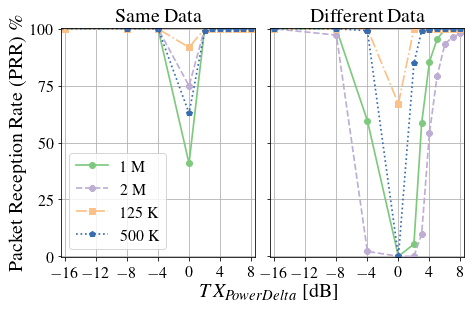

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs/evaluate_tdelta_power_0.pdf
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  4.  8.  8. 16. 20. 20. 28.]
[ 0.  4.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]


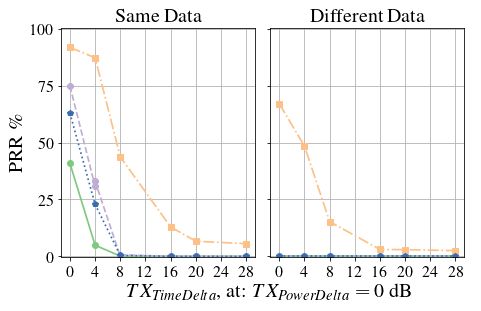

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs/evaluate_tdelta_power_-8.pdf
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  4.  8.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]


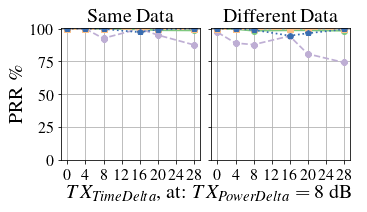

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs/evaluate_tdelta_power_2.pdf
[ 0.  4.  8. 16. 20. 28. 28.]
[ 0.  4.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]


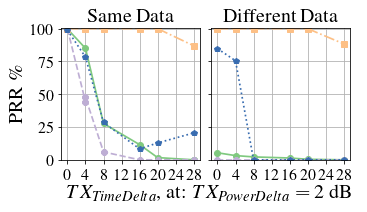

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs/evaluate_tdelta_power_4.pdf
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  4. 16. 20. 28.]
[ 0.  4.  8.  8. 16. 20. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]


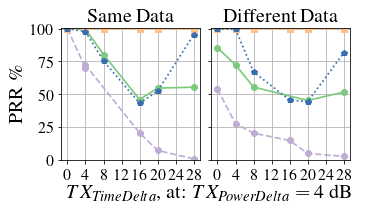

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs/evaluate_tdelta_power_8.pdf
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  4.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[0.]


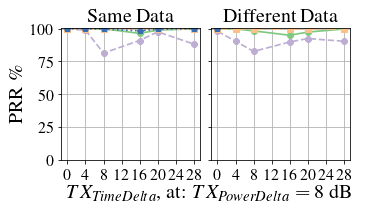

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs/evaluate_tdelta_power_-4.pdf
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  4.  8.  8. 16. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[ 0.  4.  8. 16. 20. 28.]
[0. 0. 4.]


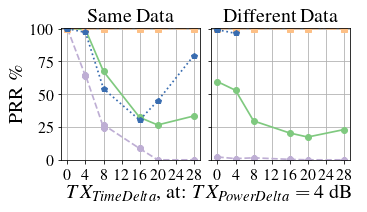

In [55]:
def plot0(wdir, results,figsize=(4,4.2),figscale=1):
#   plot_rows = 6
#   plot_cols = 2
#   plot_rows = 1
#   plot_cols = 2
#   linewidth=3
  capsize=3
  markersize=3
  linewidth=1.7
#   linestyle=linestyles[0]
 
  ncols=2
  if ncols <= 0:
    raise ValueError('doplots shall enable at least one plot.')
#   figsize=(4,4.2) #width, height
  fig, axx = plt.subplots( ncols=ncols, sharey=True, sharex=True, figsize=(ncols*figsize[0]/figscale, figsize[1]/figscale) )
#   if ncols == 1:
#     subax=[axx] #trick to allow using indexing on the axes and have the same code for both cases (single vs multiple axes)
#   else:
#     subax=axx
    
#   plot_idx = 1
  norm = matplotlib.colors.Normalize(vmin=0, vmax=6)
  
  #fig = plt.figure(figsize=(4, 6))  #width, height
#   fig, axx = plt.subplots(ncols=2, sharey=True, sharex=True,figsize=(6.75,1.25))
#   axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
#   axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

  labels = ()
  titles = ()
  txoffset = 0
  plotfilename="evaluate_txpower_plot0.pdf"
  file_name = os.path.join(wdir, plotfilename)
  print "plotting: " + file_name
  for capture in [0,1]:
#     plot_idx =1
    ax = axx[capture]
    #ax.xaxis.set_major_locator(plt.FixedLocator([-16, -8, -4, 0, 2, 4, 8]))
    ax.set_xlim(-16.5, 8.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_locator(plt.MultipleLocator(25))

    ax.set_ylim(-0.5, 100.5)
    ax.grid(True, which="both")
    if capture == 0:
      title = ax.set_title("Same Data")
    else:
      title = ax.set_title("Different Data")
    titles += (title,)
#     linestyle='--'
    for counter, ble_mode in enumerate([Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]):
      prr_txpower_list = [[r[tx_power_idx][1]-r[tx_power_idx][0], 100*r[prr_ct_idx], r[rssi_avg_idx][1]-r[rssi_avg_idx][0], r[rssi_stddev_idx][2], r[ts_delta_avg_idx][1]-r[ts_delta_avg_idx][0]] for r in results if (r[ble_mode_idx] == ble_mode) and (r[tx_offset_idx] == txoffset) and (r[capture_idx] == capture) ]
      prr_txpower_list.sort()
      prr_txpower = np.array(prr_txpower_list)
      if len(prr_txpower) > 0:
        #print plot_idx, ble_mode, prr_txpower
        if capture == 0:
          legend = "%s" %(ble_mode_str_compact(ble_mode))
        else:
          legend = None
        marker=markers[counter]
        color=plt.get_cmap('Accent')(norm(counter))
        linestyle=linestyles[counter]
#         plot_idx +=1
        plot_prr_txpower0(ax, prr_txpower, legend, linestyle, marker, color, linewidth, capsize=capsize, constant_ts_delta=0)
  
  handles, labels = axx[0].get_legend_handles_labels()
  #axx[0].locator_params(nbins=4, axis='y')
  axx[0].legend(handles, labels, loc="lower left",  ncol=1)#, bbox_to_anchor=(0.46, 1.3)) #prop={'size':12}, )
#   axx[0].legend(handles, labels, loc='lower left', borderaxespad=0.05,  ncol=1, columnspacing=0.25, labelspacing=0.25, handlelength=1.1, handletextpad=0.25, markerscale=0.5, frameon=True)
  axx[1].get_legend().set_visible(False)
  #axx[0].legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=False, shadow=False)
  x_lbl='$TX_{PowerDelta}$ [dB]'
#   x_label = axmain.set_xlabel(x_lbl)
  fig.text(0.5+fig.subplotpars.left/2, 0, x_lbl, ha='center')
  y_label = axx[0].set_ylabel('Packet Reception Rate (PRR) \%')
#   labels = (x_label,y_label)
  for ax in axx:
    for tick in ax.get_xticklabels():
      tick.set_rotation(0)
  #fig.subplots_adjust(left=0.2, hspace=0, bottom = 0, top=0, right=0.21, wspace=0 )
  fig.subplots_adjust(left=0.2, wspace=0.08, top=0.9,bottom = 0.14*figscale )
  #plt.xticks([-16, -8, -4, 0, 2, 4, 8],[-16, -8, -4, 0, 2, 4, 8])
#   fig.tight_layout()
  plt.savefig(file_name, dpi=300, bbox_inches='tight', transparent=True)
  plt.show()
#   plt.close(fig)

def plot_tdelta_power0(wdir, results,txpower = 0,show_legend=True,figsize=(4,4.2),figscale=1):
  capsize=3
  markersize=3
  linewidth=1.7
  ncols=2
  if ncols <= 0:
    raise ValueError('doplots shall enable at least one plot.')
#   figsize=(4,4.2) #width, height
  fig, axx = plt.subplots( ncols=ncols, sharey=True, sharex=True, figsize=(ncols*figsize[0]/figscale, figsize[1]/figscale) )

  norm = matplotlib.colors.Normalize(vmin=0, vmax=6)
  axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
  axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

  labels = ()
  titles = ()
  
  plotfilename="evaluate_tdelta_power_%d.pdf" % txpower
  file_name = os.path.join(wdir, plotfilename)
  print "plotting: " + file_name
  for capture in [0,1]:
    plot_idx =1
    ax = axx[capture]
    #ax.xaxis.set_major_locator(plt.FixedLocator([-16, -8, -4, 0, 2, 4, 8]))
    #ax.set_xlim(-16.5, 8.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_locator(plt.MultipleLocator(25))

    ax.set_ylim(-0.5, 100.5)
    ax.grid(True, which="both")
    if capture == 0:
      title = ax.set_title("Same Data")
    else:
      title = ax.set_title("Different Data")
    titles += (title,)
#     linestyle='--'
    for counter, ble_mode in enumerate([Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]):
      prr_txdelta_list = [[r[tx_offset_idx], 100*r[prr_ct_idx], r[rssi_avg_idx][1]-r[rssi_avg_idx][0], r[rssi_stddev_idx][2], r[ts_delta_avg_idx][1]-r[ts_delta_avg_idx][0]] for r in results if (r[ble_mode_idx] == ble_mode) and (r[tx_power_idx][1]-r[tx_power_idx][0] == txpower) and (r[capture_idx] == capture) ]
      prr_txdelta_list.sort()
      prr_txdelta = np.array(prr_txdelta_list)
      print prr_txdelta[:,0]
      if len(prr_txdelta) > 0:
        #print plot_idx, ble_mode, prr_txpower
        legend = "%s" %(ble_mode_str_compact(ble_mode))
        marker=markers[counter]
        linestyle=linestyles[counter]
        color=plt.get_cmap('Accent')(norm(counter))
        plot_idx +=1
        plot_prr_txpower0(ax, prr_txdelta, legend, linestyle, marker, color, linewidth, show_legend=show_legend, capsize=capsize)
  
  if show_legend:
    handles, labels = axx[0].get_legend_handles_labels()
      #axx[0].locator_params(nbins=4, axis='y')
      #axx[1].legend(handles, labels, loc="best",  ncol=1)#, bbox_to_anchor=(0.46, 1.3)) #prop={'size':12}, )
#       axx[1].legend(handles, labels, loc='upper center', bbox_to_anchor=(-.07, -0.25), ncol=4, prop={'size':9}, fancybox=False, shadow=False)
    axx[1].legend(handles, labels, loc='upper center', borderaxespad=0.05,  ncol=4, columnspacing=0.25, labelspacing=0.25, handlelength=1.1, handletextpad=0.25, markerscale=0.5, frameon=True)
  x_lbl='$TX_{TimeDelta}$, at: $TX_{PowerDelta}=%d$ dB' % abs(txpower) #[tick: $1/16~\mu s$]
#   x_label = axmain.set_xlabel('$TX_{TimeDelta}$, at: $TX_{PowerDelta}=%d$ dB' % abs(txpower)) #[tick: $1/16~\mu s$]
  fig.text(0.5+fig.subplotpars.left/2, 0, x_lbl, ha='center')
  y_label = axx[0].set_ylabel('PRR \%')
#   labels = (x_label,y_label)
#   fig.subplots_adjust(left=0.2, top=2, hspace=0)
  #plt.xticks([-16, -8, -4, 0, 2, 4, 8],[-16, -8, -4, 0, 2, 4, 8])
#   fig.tight_layout()
  fig.subplots_adjust(left=0.2, wspace=0.08, top=0.9,bottom = 0.14*figscale )
#   plt.savefig(file_name, bbox_inches='tight', dpi=300)
#   plt.show()
  plt.savefig(file_name, dpi=300, bbox_inches='tight', transparent=True)
  plt.show()
#   plt.close(fig)
    
def plot_prr_txpower_tsdelta_3d(fig, prr_txpower, plot_rows, plot_cols, plot_idx_, subtitle=None):
  ax = fig.add_subplot(plot_rows, plot_cols, plot_idx_, projection='3d')
  x=prr_txpower[:,0]
  y=prr_txpower[:,1]
  zs=prr_txpower[:,2]
  #ax.plot3D(x,y,zs)
  ax.plot_trisurf(x,y, zs, cmap=cm.viridis, linewidth=2)

  # vv=np.column_stack((x, y))
  # print vv.shape, vv.shape[1], vv.ndim
  # alpha_=0.5  # to accentuate the issue
  # #cc = lambda arg: colorConverter.to_rgba(arg, alpha=alpha_)
  # poly = PolyCollection(vv)
  # poly.set_alpha(alpha_)
  # ax.add_collection3d(vv, zs=zs, zdir='z')

  ax.set_zlim(-0.01, 100.1)
  ax.set_xlim(-40.01, 10)
  ax.set_ylim(-0.01, 28)
  ax.grid()
  x_label = ax.set_xlabel('$TX_{PowerDelta}$ [dB] - configured')
  y_label = ax.set_ylabel('TS [$1/16~\mu s$]')
  z_label = ax.set_zlabel('PRR \%')
  title = ax.set_title(subtitle)
  return x_label, y_label, z_label, title

def plot_prr_txpower(fig, prr_txpower, plot_rows, plot_cols, plot_idx_, subtitle=None):
  ax = fig.add_subplot(plot_rows, plot_cols, plot_idx_)
  #print prr_txpower[:,0], prr_txpower[:,1]
  ax.plot(prr_txpower[:,0], prr_txpower[:,1], linestyle='--', marker='o', color='b')
  ax.grid()
  if plot_rssi_diff_over:
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color2 = 'tab:grey'
    ax2.bar(prr_txpower[:,0], prr_txpower[:,2], yerr=prr_txpower[:,3], color=color2, capsize=linewidth*20, elinewidth=linewidth, linewidth=linewidth)    
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.grid()
    y2_label = ax2.set_ylabel('$RX_{PowerDelta}$ [dB]', color=color2)
  if plot_ts_delta_over:
    ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color3 = 'tab:grey'
    ax3.bar(prr_txpower[:,0], prr_txpower[:,4], color=color3)    
    ax3.tick_params(axis='y', labelcolor=color3)
  #ax2.grid()
  x_label = ax.set_xlabel('$TX_{PowerDelta}$ [dB] - configured')
  y_label = ax.set_ylabel('Packet Reception Rate (PRR) \%')
  title = ax.set_title(subtitle)
  return x_label, y_label, title

def autolabel(ax,rects, color='b'):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%2.1f' % (height),
                ha='center', va='bottom', color=color)
        
def plot_prr_txpower0(ax, prr_txpower, label=None, linestyle='--', marker='o', color='b', linewidth=1.6, show_legend=True, constant_ts_delta=None, capsize=3):
  #print prr_txpower[:,0], prr_txpower[:,1]
  ax.errorbar(prr_txpower[:,0], prr_txpower[:,1], label = label, linestyle=linestyle, marker=marker, color=color, linewidth=linewidth, capsize=capsize, elinewidth=linewidth)
  ax.grid()
  ax.legend().set_visible(show_legend)
  if plot_rssi_diff_over:
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color2 = 'tab:grey'
    rects=ax2.bar(prr_txpower[:,0], prr_txpower[:,2], yerr=prr_txpower[:,3], color=color, )    
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid()
    autolabel(ax2,rects)
    y2_label = ax2.set_ylabel('$RX_{PowerDelta}$ [dB]', color=color2)
  if plot_ts_delta_over:
    ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color3 = 'tab:grey'
    if constant_ts_delta is None:
        rects=ax3.bar(prr_txpower[:,0], prr_txpower[:,0] - abs(prr_txpower[:,4]), color=color,alpha = 0.5)  
    else:
        rects=ax3.bar(prr_txpower[:,0], constant_ts_delta - abs(prr_txpower[:,4]), color=color,alpha = 0.5)    

    #ax3.tick_params(axis='y', labelcolor=color)
    autolabel(ax3,rects,color=color)
    ax3.set_ylim(-3, 3)

  #return title
    
def plot(wdir, results):
  plot_rows = 6
  plot_cols = 2
  plot_idx = 1
  fig = plt.figure(figsize=(8, 8.8))  #width, height
  
  labels = ()
  titles = ()
  txoffset = 0
  plotfilename="evaluate_txpower_plot.pdf"
  file_name = os.path.join(wdir, plotfilename)
  print "plotting: " + file_name
  for capture in [0,1]:
    for ble_mode in [Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]:
      prr_txpower_list = [[r[tx_power_idx][1]-r[tx_power_idx][0], 100*r[prr_ct_idx], r[rssi_avg_idx][1]-r[rssi_avg_idx][0], r[rssi_stddev_idx][2], r[ts_delta_avg_idx][1]-r[ts_delta_avg_idx][0]] for r in results if (r[ble_mode_idx] == ble_mode) and (r[tx_offset_idx] == txoffset) and (r[capture_idx] == capture) ]
      prr_txpower_list.sort()
      prr_txpower = np.array(prr_txpower_list)
      if len(prr_txpower) > 0:
        #print plot_idx, ble_mode, prr_txpower
        subtitle = "ble_mode_%s_txoffset_%d_capture_%d" %(ble_mode_str_compact(ble_mode), txoffset, capture)
        x_label_tx, y_label_tx, title = plot_prr_txpower(fig, prr_txpower, plot_rows, plot_cols, plot_idx, subtitle)
        labels += (x_label_tx,y_label_tx,)
        titles += (title,)
        plot_idx +=1

  plt.subplots_adjust(left=0.2, top=2)
  plt.savefig(file_name, dpi=300, bbox_extra_artists=labels, bbox_inches='tight')
  #plt.show()
  plt.close(fig)

  plot_idx = 1
  fig = plt.figure(figsize=(8, 8.8))  #width, height
  
  labels = ()
  titles = ()
  plotfilename="evaluate_txpower_txoffset_plot.pdf"
  file_name = os.path.join(wdir, plotfilename)
  print "plotting: " + file_name
  for capture in [0,1]:
    for ble_mode in [Ble_1Mbit, Ble_2Mbit, Ble_LR125Kbit, Ble_LR500Kbit]:
      prr_txpower_list = [[r[tx_power_idx][1]-r[tx_power_idx][0], r[tx_offset_idx], 100*r[prr_ct_idx], r[rssi_avg_idx][1]-r[rssi_avg_idx][0], r[rssi_stddev_idx][2], r[ts_delta_avg_idx][1]-r[ts_delta_avg_idx][0]] for r in results if (r[ble_mode_idx] == ble_mode) and (r[capture_idx] == capture) ]
      prr_txpower_list.sort(key = operator.itemgetter(1,0))
      prr_txpower = np.array(prr_txpower_list)
      if len(prr_txpower) > 0:
        #print plot_idx, ble_mode, prr_txpower
        subtitle = "ble_mode_%s_capture_%d" %(ble_mode_str(ble_mode), capture)
        x_label_tx, y_label_tx, z_label, title = plot_prr_txpower_tsdelta_3d(fig, prr_txpower, plot_rows, plot_cols, plot_idx, subtitle)
        labels += (x_label_tx,y_label_tx,z_label,)
        titles += (title,)
        plot_idx +=1
  plt.subplots_adjust(left=0.2, top=2)
  plt.savefig(file_name, dpi=300, bbox_extra_artists=labels, bbox_inches='tight')
  plt.show()
#   plt.close(fig)

    
plot_ts_delta_over = False
plot_rssi_diff_over = False
########### big figures
figsize=(4,4.2)
X_SMALL_SIZE = 8*2
SMALL_SIZE = 10*2
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

rc('font', size=SMALL_SIZE)          # controls default text sizes
rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=X_SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=X_SMALL_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=X_SMALL_SIZE)    # legend fontsize
#plot(wdir2, results2)
plot0(wdir2, results2,figsize=figsize)
plot_tdelta_power0(wdir2, results2, txpower = 0,show_legend=False,figsize=figsize)
########## small figures
figscale=1.5
figsize=(4.3,4.0)
# X_SMALL_SIZE = 1.5*8*2
# SMALL_SIZE = 1.3*10*2
# MEDIUM_SIZE = 1.2*12*2
# BIGGER_SIZE = 1.2*14*2

# rc('font', size=SMALL_SIZE)          # controls default text sizes
# rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
# rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
# rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# rc('xtick', labelsize=X_SMALL_SIZE)    # fontsize of the tick labels
# rc('ytick', labelsize=X_SMALL_SIZE)    # fontsize of the tick labels
# rc('legend', fontsize=X_SMALL_SIZE)    # legend fontsize

plot_tdelta_power0(wdir2, results2, txpower = -8,show_legend=False,figsize=figsize,figscale=figscale)
plot_tdelta_power0(wdir2, results2, txpower = 2,show_legend=False,figsize=figsize,figscale=figscale)
plot_tdelta_power0(wdir2, results2, txpower = 4,show_legend=False,figsize=figsize,figscale=figscale)
plot_tdelta_power0(wdir2, results2, txpower = 8,show_legend=False,figsize=figsize,figscale=figscale)
plot_tdelta_power0(wdir2, results2, txpower = -4,show_legend=False,figsize=figsize,figscale=figscale)

In [1530]:
for lline in [":A..--CC...", ":B---CCC--.....", ":-BBBBBBBB.....", ":B--------.....",":A.......-BBBB."]:
    print lline
    ch=lline[1]
    #replace left dots with the letter, and remove the right dots!
    lline=re.sub(r'\.*$',r'',lline)
    lline=lline.replace('.',ch) #replace .
    lline = lline[1:]      
    print lline


:A..--CC...
AAA--CC
:B---CCC--.....
B---CCC--
:-BBBBBBBB.....
-BBBBBBBB
:B--------.....
B--------
:A.......-BBBB.
AAAAAAAA-BBBB


In [7]:
! open -a Preview /Users/beshr/work/blueflood/examples/nrf-glossy/exp-logs/evaluate_*.pdf
#! open -a Preview /Users/beshr/work/chaos/examples/nrf-glossy/exp-logs/evaluate_txpower_plot0.pdf